## ***Vasilii Mosin***

# Santander Product Recommendation

In this competition, there are 1.5 years of customers behavior data from Santander bank to predict what new products customers will purchase. The data starts at 2015-01-28 and has monthly records of products a customer has, such as "credit card", "savings account", etc. The goal is to predict what additional products a customer will get in the last month, 2016-06-28, in addition to what they already have at 2016-05-28. These products are the columns named: ind_(xyz)_ult1, which are the columns #25 - #48 in the training data.

Submissions in this competition are evaluated according to the Mean Average Precision @ 7 (MAP@7). It means that it is needed to predict no more than 7 products for every customer. Note that order matters. But it depends. Order matters only if there is at least one incorrect prediction. In other words, if all predictions are correct, it doesn't matter in which order they are given. This makes sense to show up first the most relevant results.

## Abstract

1. Data exploration and visualization. Trying to understand data, to find some trends in it.
2. Data preprocessing. Preparing train and test data to put them in models. Thinking about missing values.
3. Training and predicting. Trying to apply some models.
    * Some out-of-the-box solution (i.e. XGBoost). Set the result as a baseline score.
    * Trying to beat the baseline score using Neural Networks.
    * In case of enough time, expirements with Collaborative Filtering in Spark.
4. Comparing and Analysis of the Results. Conclusions.

In [1]:
import csv
import random
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline
color = sns.color_palette()
plt.style.use('seaborn-whitegrid')
from sklearn.neighbors import KNeighborsClassifier

## 1. Data Exploration and Visualization

For data exploration I try to look on the small subsample of the train dataset first because I have no machine at the moment with enough RAM to operate with the whole dataset. Subsample is good for getting an overview of the dataset.

Also, I have to find some way to overcome the lack of RAM. So, maybe there is something interesting can be found in data.

In [3]:
random.seed(126)
skip_subsample = random.sample(range(1,13647309), 13000000)

In [4]:
data = pd.read_csv('train_ver2.csv', skiprows=skip_subsample)

/home/vasiliy/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (5,8,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
data.head()

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-01-28,1050616,N,ES,H,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050591,N,ES,H,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
2,2015-01-28,1050604,N,ES,H,53,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
3,2015-01-28,1050711,N,ES,V,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
4,2015-01-28,1050492,N,ES,V,25,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0


Some of the subsample's statistics..

In [7]:
data.describe()

,ncodpers,ind_nuevo,indrel,tipodom,cod_prov,ind_actividad_cliente,renta,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
count,6.473090e+05,645982.000000,645982.000000,645982.0,642923.000000,645982.000000,5.145510e+05,647309.000000,647309.000000,647309.000000,...,647309.000000,647309.000000,647309.000000,647309.000000,647309.000000,647309.000000,647309.000000,646569.000000,646569.000000,647309.000000
mean,8.352199e+05,0.059746,1.186145,1.0,26.585067,0.457217,1.341768e+05,0.000091,0.000032,0.655162,...,0.005877,0.009110,0.002541,0.052420,0.044291,0.025529,0.003893,0.054532,0.059160,0.128120
std,4.316020e+05,0.237016,4.267029,0.0,12.766731,0.498167,2.245185e+05,0.009547,0.005696,0.475316,...,0.076434,0.095011,0.050347,0.222873,0.205741,0.157725,0.062273,0.227066,0.235924,0.334223
min,1.588900e+04,0.000000,1.000000,1.0,1.000000,0.000000,2.336010e+03,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.526890e+05,0.000000,1.000000,1.0,15.000000,0.000000,6.883196e+04,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.325950e+05,0.000000,1.000000,1.0,28.000000,0.000000,1.019404e+05,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.198959e+06,0.000000,1.000000,1.0,35.000000,1.000000,1.560167e+05,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.553663e+06,1.000000,99.000000,1.0,52.000000,1.000000,2.889440e+07,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Display columns' names..

In [6]:
data.columns

Index([u'fecha_dato', u'ncodpers', u'ind_empleado', u'pais_residencia',
       u'sexo', u'age', u'fecha_alta', u'ind_nuevo', u'antiguedad', u'indrel',
       u'ult_fec_cli_1t', u'indrel_1mes', u'tiprel_1mes', u'indresi',
       u'indext', u'conyuemp', u'canal_entrada', u'indfall', u'tipodom',
       u'cod_prov', u'nomprov', u'ind_actividad_cliente', u'renta',
       u'segmento', u'ind_ahor_fin_ult1', u'ind_aval_fin_ult1',
       u'ind_cco_fin_ult1', u'ind_cder_fin_ult1', u'ind_cno_fin_ult1',
       u'ind_ctju_fin_ult1', u'ind_ctma_fin_ult1', u'ind_ctop_fin_ult1',
       u'ind_ctpp_fin_ult1', u'ind_deco_fin_ult1', u'ind_deme_fin_ult1',
       u'ind_dela_fin_ult1', u'ind_ecue_fin_ult1', u'ind_fond_fin_ult1',
       u'ind_hip_fin_ult1', u'ind_plan_fin_ult1', u'ind_pres_fin_ult1',
       u'ind_reca_fin_ult1', u'ind_tjcr_fin_ult1', u'ind_valo_fin_ult1',
       u'ind_viv_fin_ult1', u'ind_nomina_ult1', u'ind_nom_pens_ult1',
       u'ind_recibo_ult1'],
      dtype='object')

Have a look on the missing data. Of course, there is not a representative sample and it can be another missing data in other parts of the dataset. However, in any case..even here we can already see some columns with missing data..

In [8]:
data.isnull().any()

fecha_dato               False
ncodpers                 False
ind_empleado              True
pais_residencia           True
sexo                      True
age                      False
fecha_alta                True
ind_nuevo                 True
antiguedad               False
indrel                    True
ult_fec_cli_1t            True
indrel_1mes               True
tiprel_1mes               True
indresi                   True
indext                    True
conyuemp                  True
canal_entrada             True
indfall                   True
tipodom                   True
cod_prov                  True
nomprov                   True
ind_actividad_cliente     True
renta                     True
segmento                  True
ind_ahor_fin_ult1        False
ind_aval_fin_ult1        False
ind_cco_fin_ult1         False
ind_cder_fin_ult1        False
ind_cno_fin_ult1         False
ind_ctju_fin_ult1        False
ind_ctma_fin_ult1        False
ind_ctop_fin_ult1        False
ind_ctpp

Aha.. Good. We see that two target features have missing values and the majority of the input features have unknown values also.

Ok.. Now, let's explore some interesting fetures apart but on the whole dataset..

Let us check the number of times the given product has been bought in the train dataset.

In [14]:
del data
data = pd.read_csv('train_ver2.csv', dtype='float16', 
                    usecols=['ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 
                             'ind_cco_fin_ult1', 'ind_cder_fin_ult1',
                             'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
                             'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1',
                             'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1',
                             'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
                             'ind_ecue_fin_ult1', 'ind_fond_fin_ult1',
                             'ind_hip_fin_ult1', 'ind_plan_fin_ult1',
                             'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
                             'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1',
                             'ind_viv_fin_ult1', 'ind_nomina_ult1',
                             'ind_nom_pens_ult1', 'ind_recibo_ult1'])

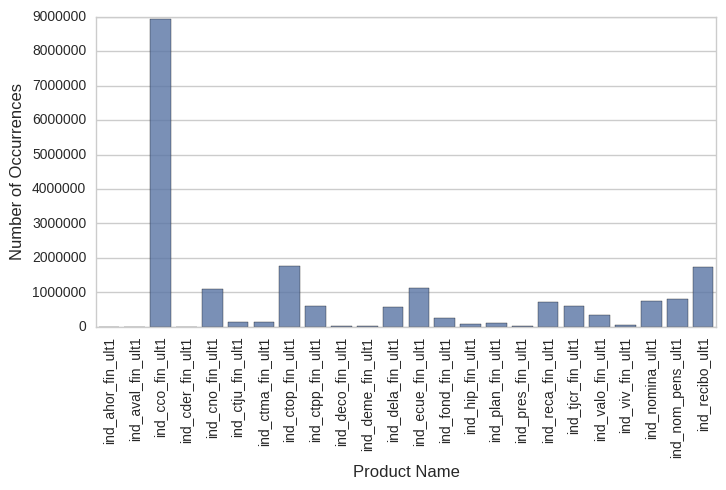

In [23]:
target_counts = data.astype('float64').sum(axis=0)
plt.figure(figsize=(8,4))
sns.barplot(target_counts.index, target_counts.values, color=color[0], alpha=0.8)
plt.xlabel('Product Name', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

It is easy to see that the product "ind_cco_fin_ult1" is the most popular one, while products "ind_ahor_fin_ult1" and "ind_aval_fin_ult1" have very small numbers of boughts. This fact can be used further in the data preparation section in order to reduce the training data size.

Next, let us explore the dates now and see if there are any insights. There are 2 date fields present in the data.
1. fecha_dato - The date of observation
2. fecha_alta - The date in which the customer became as the first holder of a contract in the bank

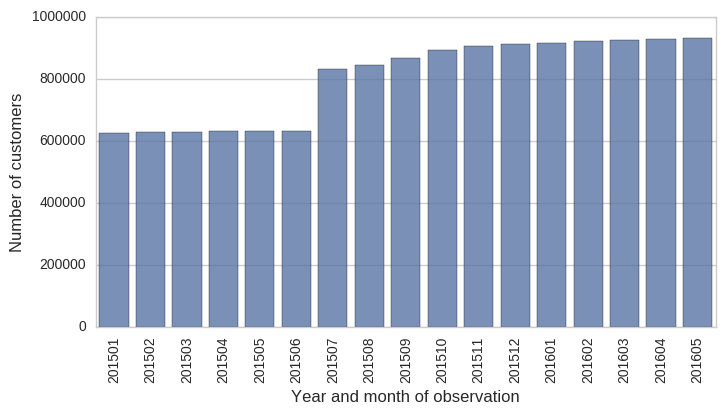

In [26]:
data = pd.read_csv('train_ver2.csv', usecols=['fecha_dato', 'fecha_alta'], parse_dates=['fecha_dato', 'fecha_alta'])
data['fecha_dato_yearmonth'] = data['fecha_dato'].apply(lambda x: (100*x.year) + x.month)
yearmonth = data['fecha_dato_yearmonth'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(yearmonth.index, yearmonth.values, alpha=0.8, color=color[0])
plt.xlabel('Year and month of observation', fontsize=12)
plt.ylabel('Number of customers', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

It's seems like the data is partitioned by half after June 2015. Remember this fact. By the way, our goal is to predict new products in June 2016.

('Minimum value of fetcha_alta : ', 199501.0)
('Maximum value of fetcha_alta : ', 201605.0)


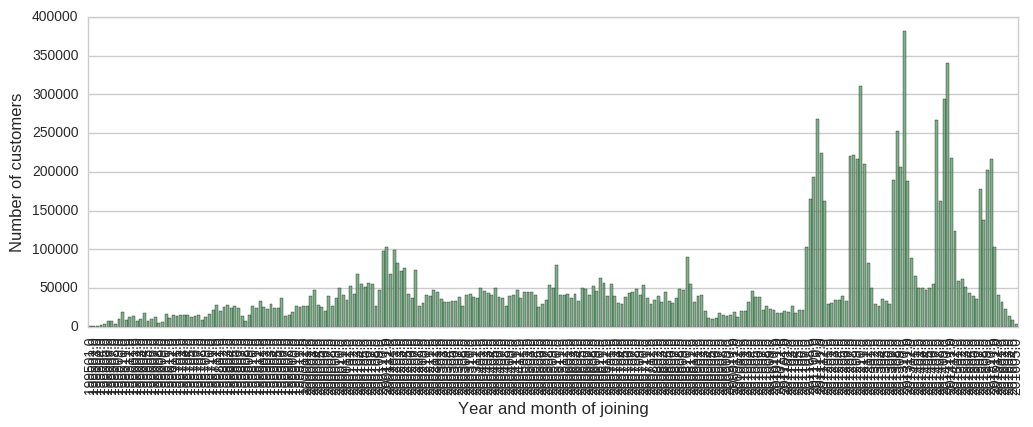

In [28]:
data['fecha_alta_yearmonth'] = data['fecha_alta'].apply(lambda x: (100*x.year) + x.month)
yearmonth = data['fecha_alta_yearmonth'].value_counts()
print("Minimum value of fetcha_alta : ", min(yearmonth.index))
print("Maximum value of fetcha_alta : ", max(yearmonth.index))

plt.figure(figsize=(12,4))
sns.barplot(yearmonth.index, yearmonth.values, alpha=0.8, color=color[1])
plt.xlabel('Year and month of joining', fontsize=12)
plt.ylabel('Number of customers', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

So the first holder date starts from January 1995. But as we can see, the number is high during the recent years.!

Also it seems there are some seasonal peaks in the data. Let us have a close look at them.!

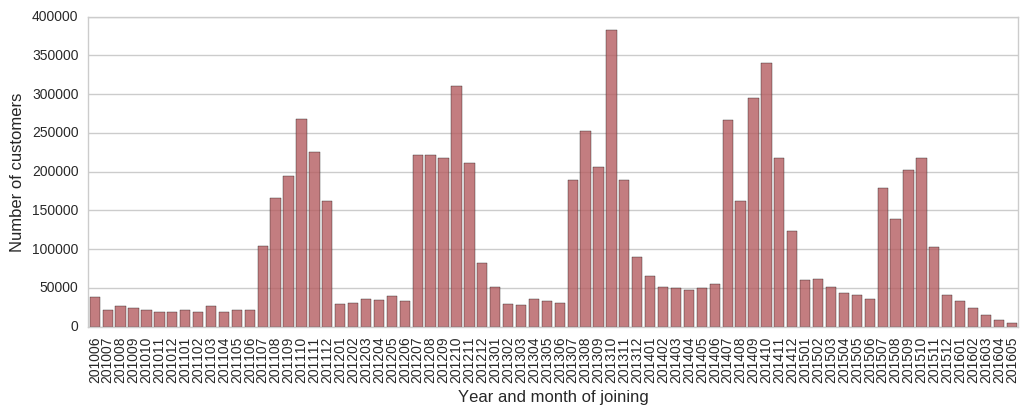

In [29]:
year_month = yearmonth.sort_index().reset_index()
year_month = year_month.ix[185:]
year_month.columns = ['yearmonth', 'number_of_customers']

plt.figure(figsize=(12,4))
sns.barplot(year_month.yearmonth.astype('int'), year_month.number_of_customers, alpha=0.8, color=color[2])
plt.xlabel('Year and month of joining', fontsize=12)
plt.ylabel('Number of customers', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

From 2011, the number of customers becoming the first holder of a contract in the second six months is much higher than the first six months in a calendar year and it is across all years after that. June is like an edge between the the two seasons. It is a very specific month.

Let's have a look probably on the most important numerical feature from the input space. Age.

Checking the number of missing values, distribution on the train and test. 

In [30]:
del data
train = pd.read_csv('train_ver2.csv', usecols=['age'])
print(list(train.age.unique()))

[' 35', ' 23', ' 22', ' 24', ' 65', ' 28', ' 25', ' 26', ' 53', ' 27', ' 32', ' 37', ' 31', ' 39', ' 63', ' 33', ' 55', ' 42', ' 58', ' 38', ' 50', ' 30', ' 45', ' 44', ' 36', ' 29', ' 60', ' 57', ' 67', ' 47', ' NA', ' 34', ' 48', ' 46', ' 54', ' 84', ' 15', ' 12', '  8', '  6', ' 83', ' 40', ' 77', ' 69', ' 52', ' 59', ' 43', ' 10', '  9', ' 49', ' 41', ' 51', ' 78', ' 16', ' 11', ' 73', ' 62', ' 66', ' 17', ' 68', ' 82', ' 95', ' 96', ' 56', ' 61', ' 79', ' 72', ' 14', ' 19', ' 13', ' 86', ' 64', ' 20', ' 89', ' 71', '  7', ' 70', ' 74', ' 21', ' 18', ' 75', '  4', ' 80', ' 81', '  5', ' 76', ' 92', ' 93', ' 85', ' 91', ' 87', ' 90', ' 94', ' 99', ' 98', ' 88', ' 97', '100', '101', '106', '103', '  3', '  2', '102', '104', '111', '107', '109', '105', '112', '115', '110', '116', '108', '113', 37, 81, 43, 30, 45, 41, 67, 59, 46, 36, 47, 69, 39, 44, 40, 38, 34, 42, 31, 35, 48, 60, 54, 51, 33, 62, 50, 11, 57, 55, 85, 80, 70, 32, 52, 94, 61, 13, 29, 49, 76, 28, 63, 10, 88, 68, 64, 58, 56

/home/vasiliy/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


There are quite a few different formats for age (number, string with leading spaces, string). Also if we see, there is a ' NA' value present in this field. So we should remember that while preprocessing the data. However, yet we can just replace 'NA' to np.nan.

In [31]:
train['age'] = train['age'].replace(to_replace=[' NA'], value=np.nan)

Plot the distribution..

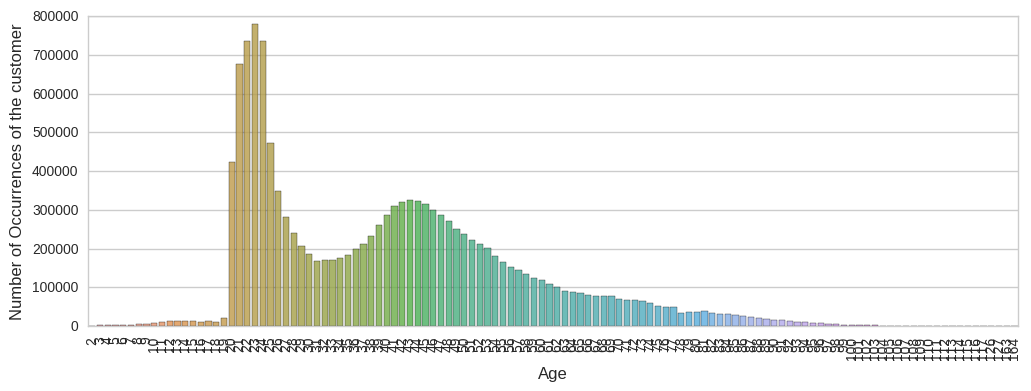

In [32]:
train['age'] = train['age'].astype('float64')

age_series = train.age.value_counts()
plt.figure(figsize=(12,4))
sns.barplot(age_series.index.astype('int'), age_series.values, alpha=0.8)
plt.ylabel('Number of Occurrences of the customer', fontsize=12)
plt.xlabel('Age', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

We could see that there is a very long tail at both the ends. So we can just cut them in the preprocessing section.

In [33]:
train.age.isnull().sum()

27734

In [34]:
train.age.mean()

40.181464913552738

We have 27734 missing values and the mean age is 40. We could probably do a mean imputation here.

We could look at test set age distribution to confirm both train and test have same distribution.

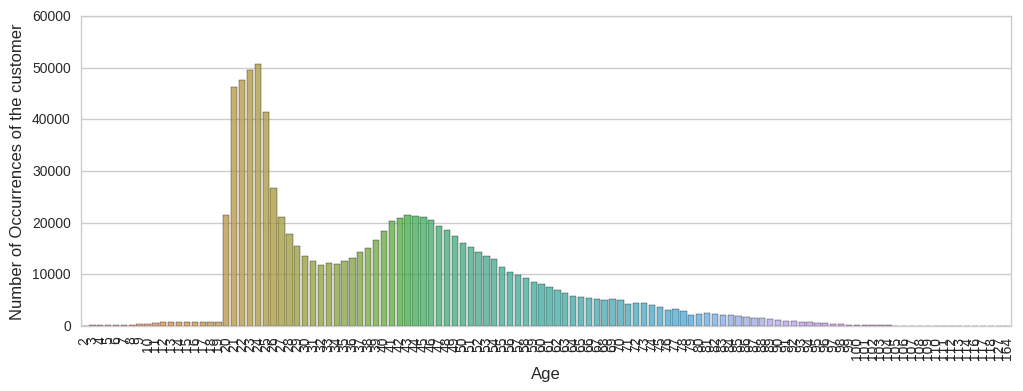

In [36]:
test = pd.read_csv('test_ver2.csv', usecols=['age'])
test['age'] = test['age'].replace(to_replace=[' NA'], value=np.nan)
test['age'] = test['age'].astype('float64')

age_series = test.age.value_counts()
plt.figure(figsize=(12,4))
sns.barplot(age_series.index.astype('int'), age_series.values, alpha=0.8)
plt.ylabel('Number of Occurrences of the customer', fontsize=12)
plt.xlabel('Age', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

Good to see that the distribution is similar between train and test.

Further, I want to explore the other two numerical features in the datase. Firstly, let's look on the antiguedad feature that is customer seniority in months.

In [2]:
data = pd.read_csv('train_ver2.csv', usecols=['antiguedad'])
print(list(data.antiguedad.unique()))

['      6', '     35', '     34', '     NA', '     33', '     31', '     21', '     16', '     27', '      9', '     22', '     13', '     29', '      8', '     11', '     10', '     28', '     24', '      7', '     25', '     14', '     26', '     12', '     23', '      1', '     18', '      4', '      3', '     17', '     32', '     30', '     20', '     15', '     19', '    157', '     36', '      5', '     40', '     38', '     37', '     39', '      0', '      2', '     47', '     44', '     42', '     46', '     45', '     43', '     41', '     57', '     48', '     52', '     49', '     50', '     56', '     58', '     51', '     55', '     54', '     53', '     59', '     62', '     61', '     60', '     63', '    139', '    165', '    118', '    164', '    142', '     94', '    159', '    143', '    105', '    151', '    162', '    137', '    150', '    128', '    122', '    156', '    119', '    160', '     79', '     95', '    132', '    161', '     98', '    127', '     72'

/home/vasiliy/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Again. here we see the different data format (strings and numbers). Also there are some special values, like 'NA' and -999999. Let's plot the distribution on train and test data.

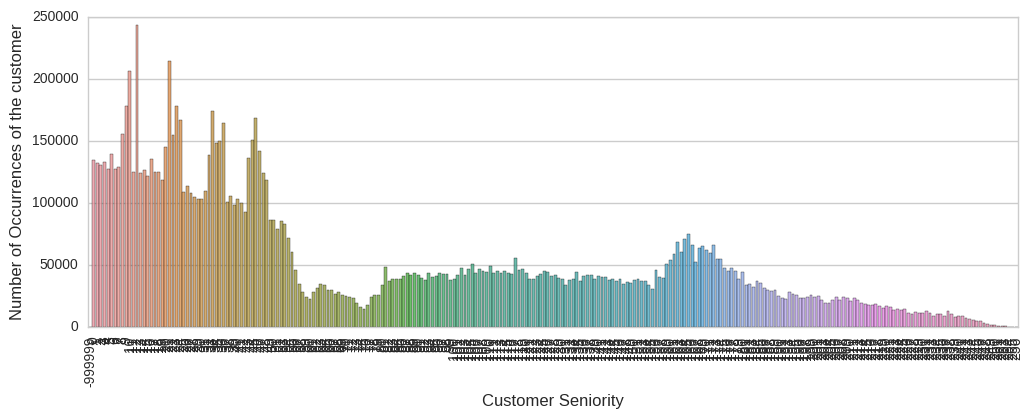

In [5]:
data['antiguedad'] = data['antiguedad'].replace(to_replace=['     NA'], value=np.nan)
data['antiguedad'] = data['antiguedad'].astype('float64')

col_series = data.antiguedad.value_counts()
plt.figure(figsize=(12,4))
sns.barplot(col_series.index.astype('int'), col_series.values, alpha=0.8)
plt.ylabel('Number of Occurrences of the customer', fontsize=12)
plt.xlabel('Customer Seniority', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

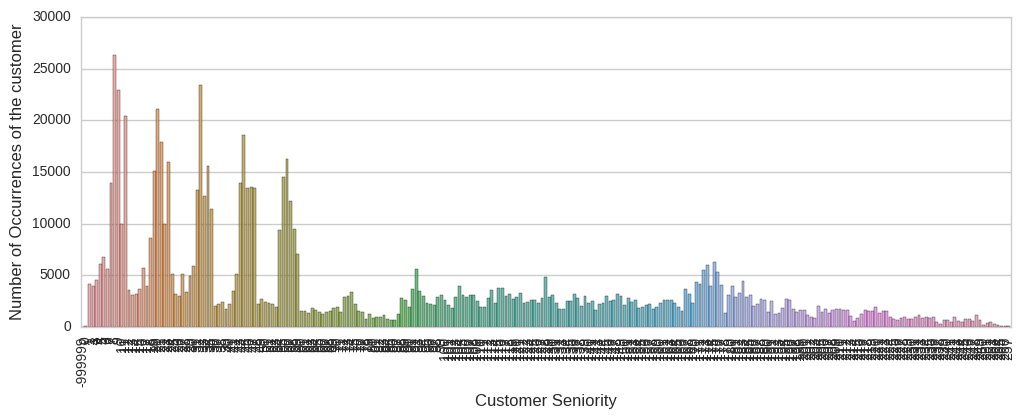

In [8]:
test = pd.read_csv('test_ver2.csv', usecols=['antiguedad'])
test['antiguedad'] = test['antiguedad'].replace(to_replace=[' NA'], value=np.nan)
test['antiguedad'] = test['antiguedad'].astype('float64')

col_series = test.antiguedad.value_counts()
plt.figure(figsize=(12,4))
sns.barplot(col_series.index.astype('int'), col_series.values, alpha=0.8)
plt.ylabel('Number of Occurrences of the customer', fontsize=12)
plt.xlabel('Customer Seniority', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

The distrubutions are pretty much the same, the picks are identical. Good. Preprocessing this feature in the same way as for the age.

Another, and the last numerical feature, is renta that is gross income of the household. Very important one in the sence of the customers behavior.

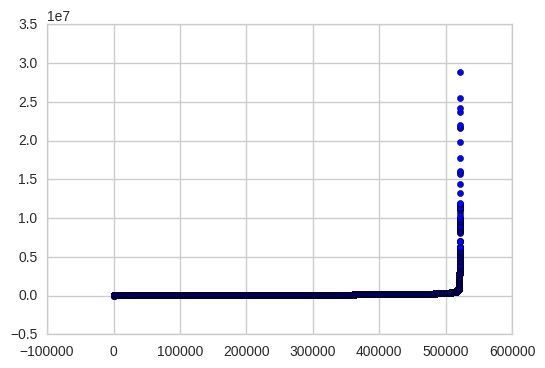

In [9]:
data = pd.read_csv('train_ver2.csv', usecols=['renta'])
unique_values = np.sort(data.renta.unique())
plt.scatter(range(len(unique_values)), unique_values)
plt.show()

There are few very high valued customers present in the data.

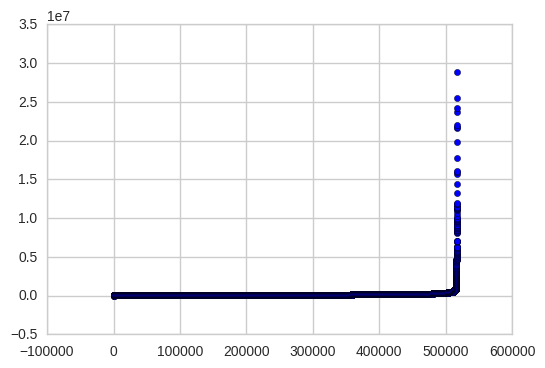

In [11]:
test = pd.read_csv('test_ver2.csv', usecols=['renta'])
test['renta'] = test['renta'].replace(to_replace=['         NA'], value=np.nan).astype('float') 
# note that there is NA value in test
unique_values = np.sort(test.renta.unique())
plt.scatter(range(len(unique_values)), unique_values)
plt.show()

Now let us see how the targets are distributed based on the numerical variables present in the data. Let us subset the first 100K rows.

In [14]:
train = pd.read_csv("train_ver2.csv", nrows=100000)
target_cols = ['ind_cco_fin_ult1', 'ind_cder_fin_ult1',
                             'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
                             'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1',
                             'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1',
                             'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
                             'ind_ecue_fin_ult1', 'ind_fond_fin_ult1',
                             'ind_hip_fin_ult1', 'ind_plan_fin_ult1',
                             'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
                             'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1',
                             'ind_viv_fin_ult1', 'ind_nomina_ult1',
                             'ind_nom_pens_ult1', 'ind_recibo_ult1']
train[target_cols] = (train[target_cols].fillna(0))
train["age"] = train['age'].map(str.strip).replace(['NA'], value=0).astype('float')
train["antiguedad"] = train["antiguedad"].map(str.strip)
train["antiguedad"] = train['antiguedad'].replace(['NA'], value=0).astype('float')
train["antiguedad"].ix[train["antiguedad"]>65] = 65 # there is one very high skewing the graph
train["renta"].ix[train["renta"]>1e6] = 1e6 # capping the higher values for better visualisation
train.fillna(-1, inplace=True)

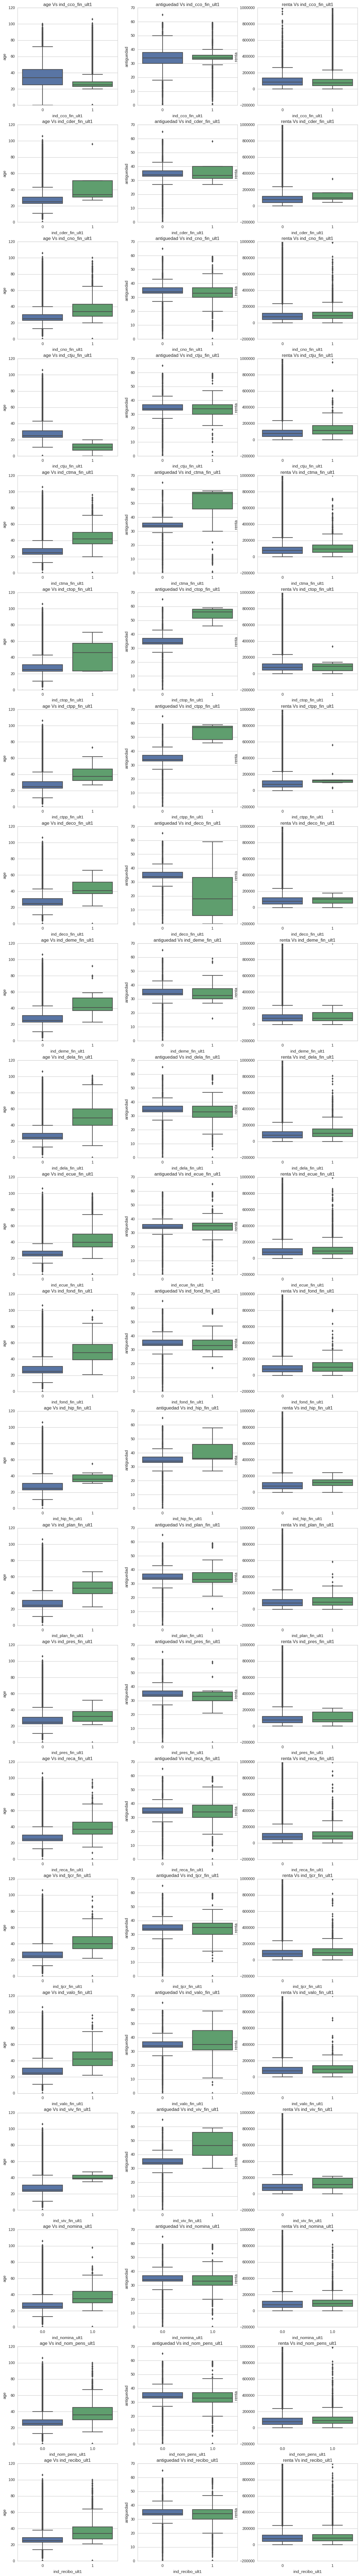

In [15]:
fig = plt.figure(figsize=(16, 120))
numeric_cols = ['age', 'antiguedad', 'renta']
plot_count = 0
for ind, target_col in enumerate(target_cols):
    for numeric_col in numeric_cols:
        plot_count += 1
        plt.subplot(22, 3, plot_count)
        sns.boxplot(x=target_col, y=numeric_col, data=train)
        plt.title(numeric_col+" Vs "+target_col)
plt.show()

Seems all these numerical variables have some predictive power since they show some different behavior between 0's and 1's.

Now let us look at the distribution of categorical fields present in the data by using the first 1 million rows.

Number of unique values in  ind_empleado  :  6


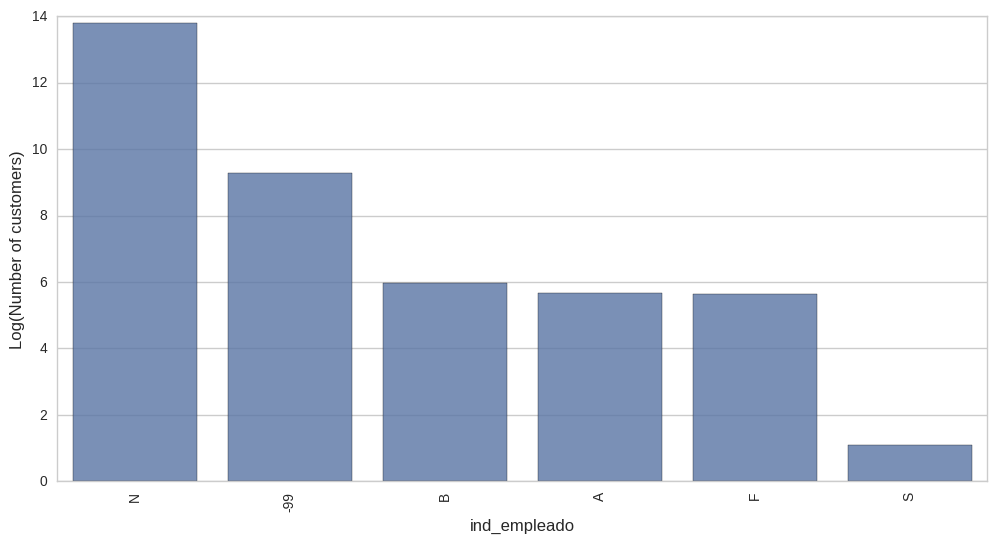


Number of unique values in  pais_residencia  :  114


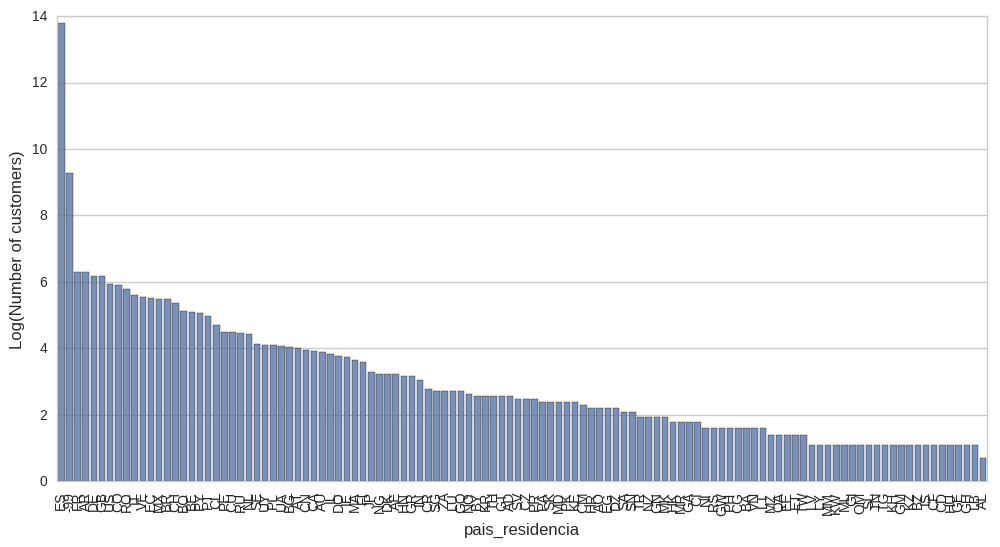


Number of unique values in  sexo  :  3


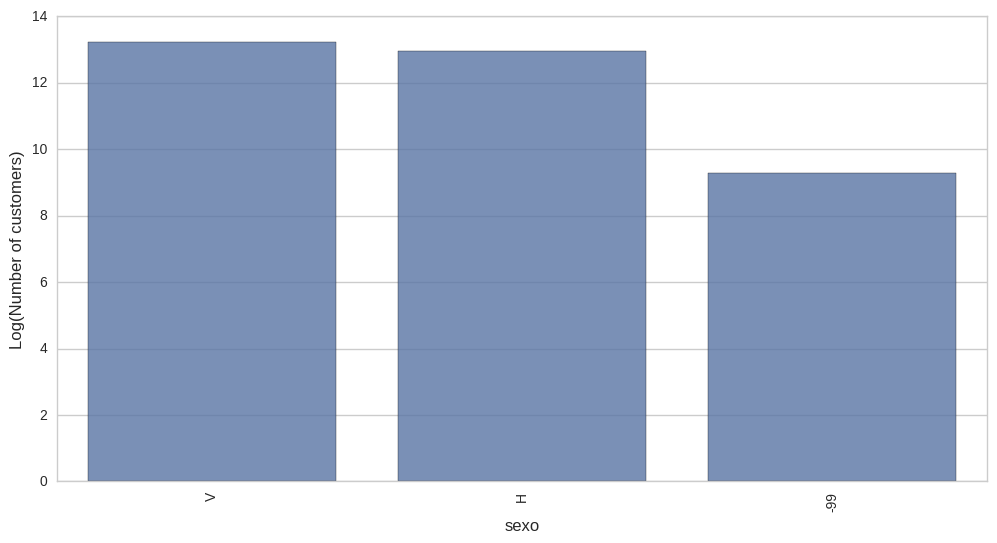


Number of unique values in  ind_nuevo  :  3


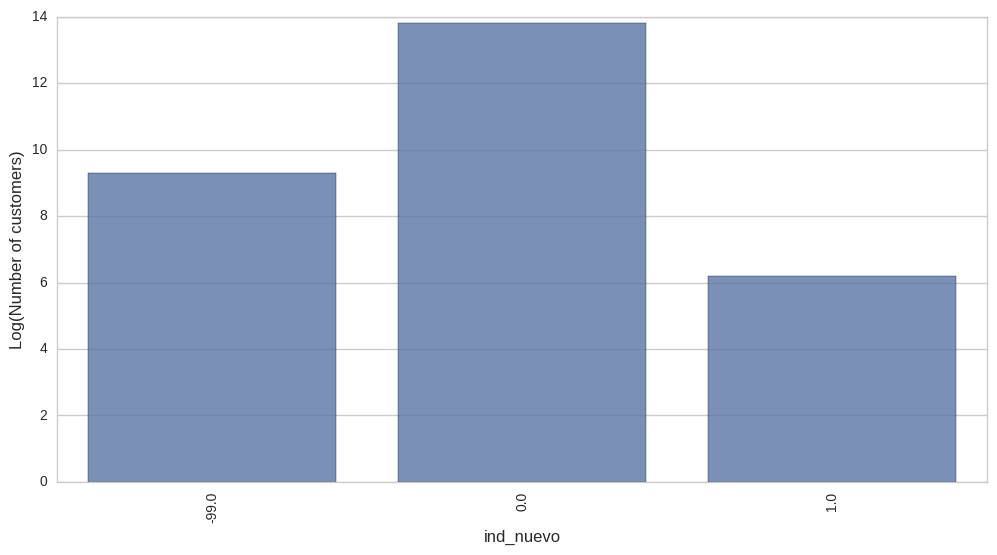


Number of unique values in  indrel  :  3


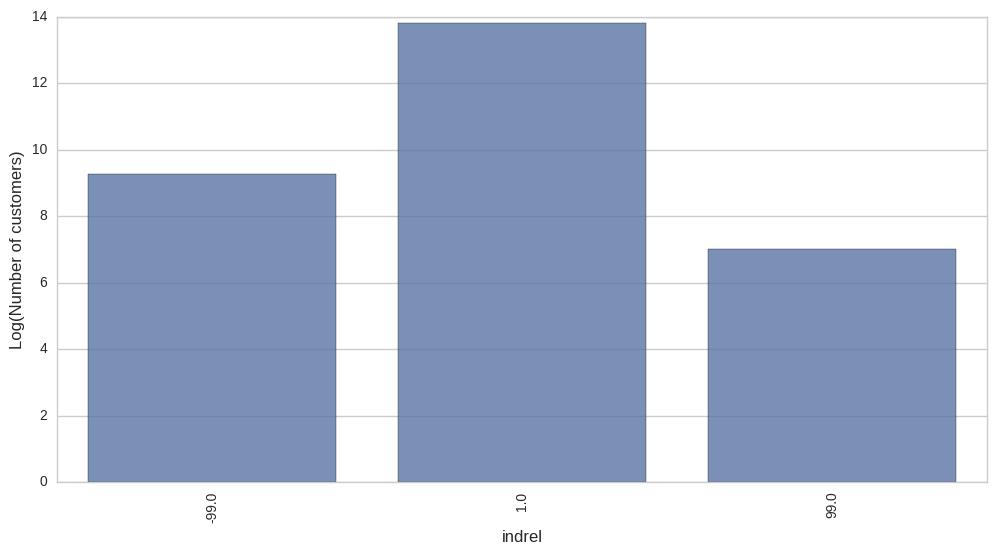


Number of unique values in  ult_fec_cli_1t  :  23


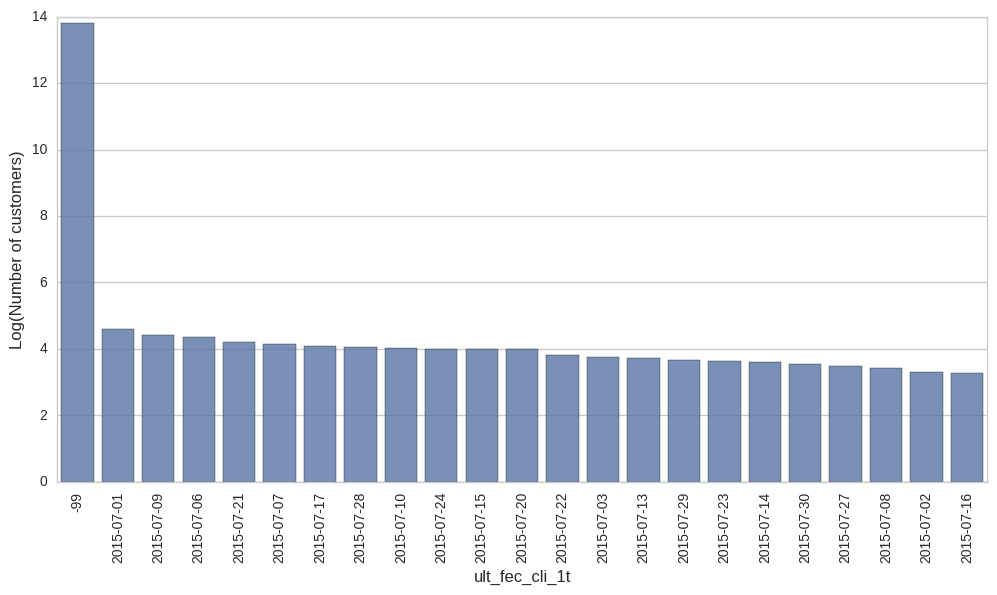


Number of unique values in  indrel_1mes  :  4


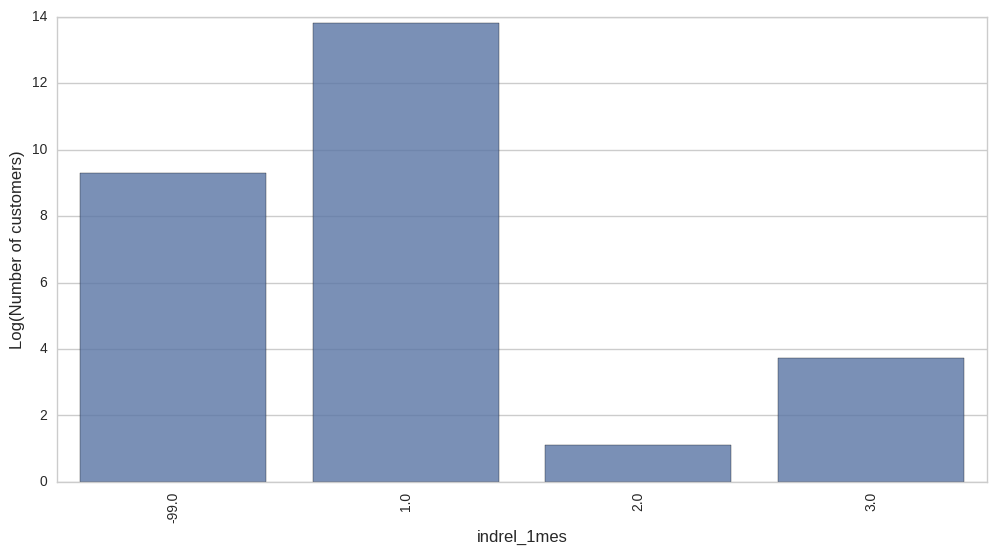


Number of unique values in  tiprel_1mes  :  4


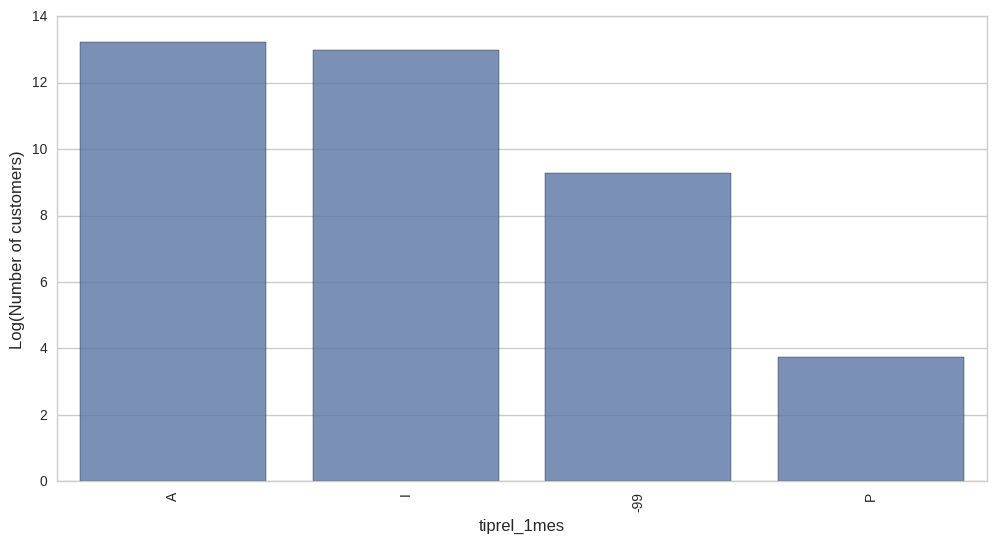


Number of unique values in  indresi  :  3


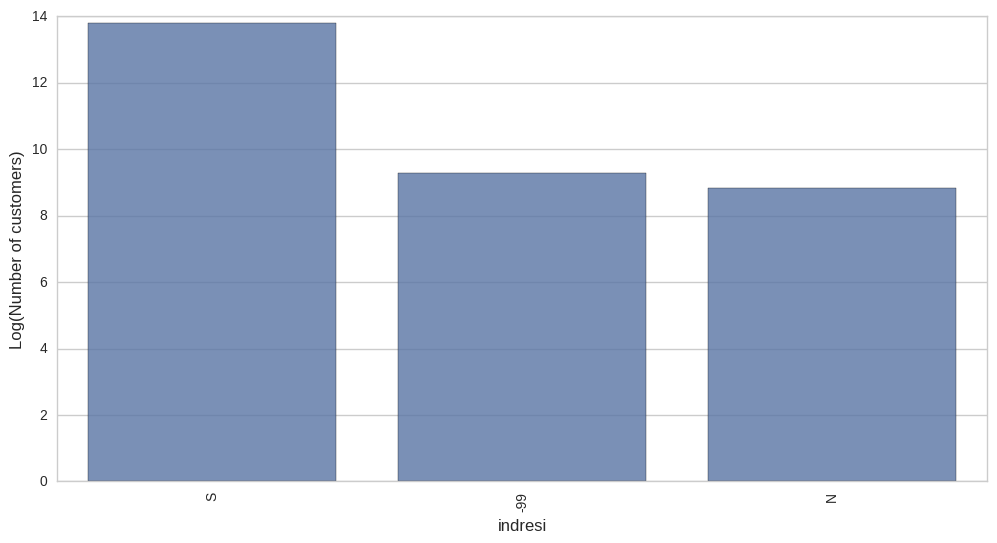


Number of unique values in  indext  :  3


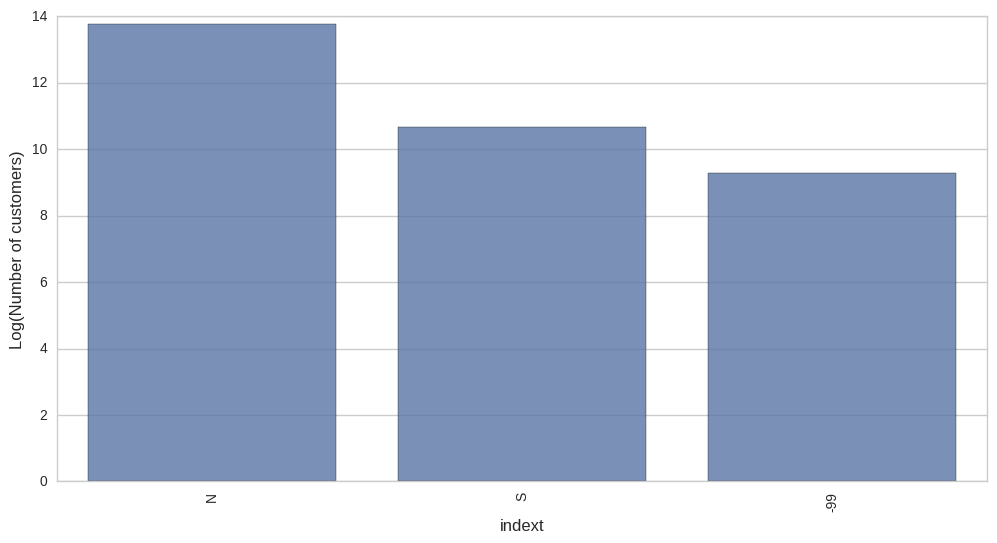


Number of unique values in  conyuemp  :  3


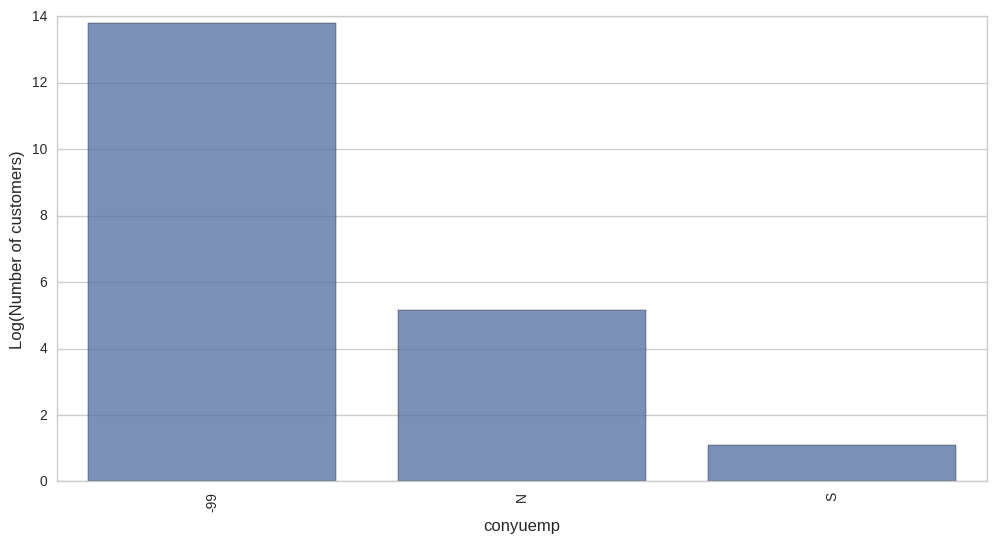


Number of unique values in  canal_entrada  :  157


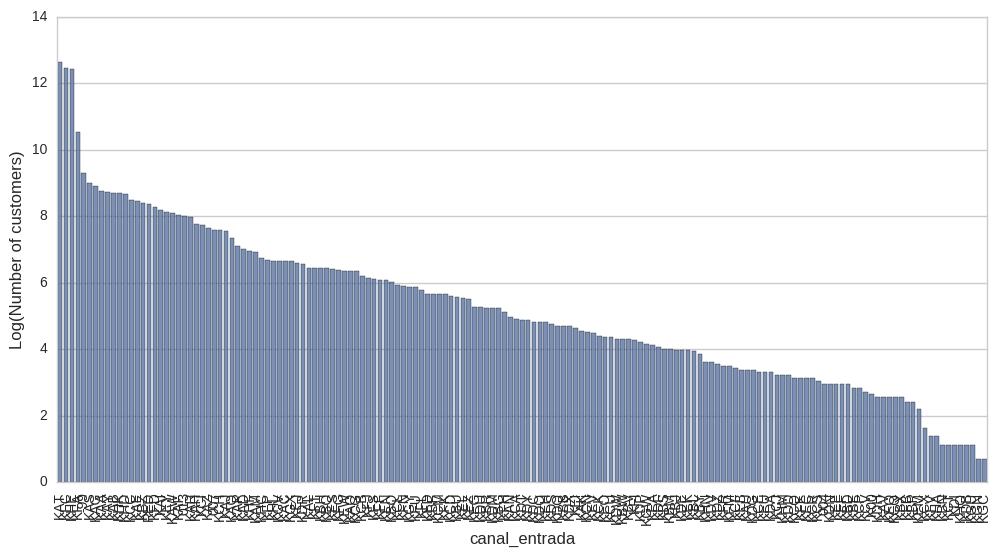


Number of unique values in  indfall  :  3


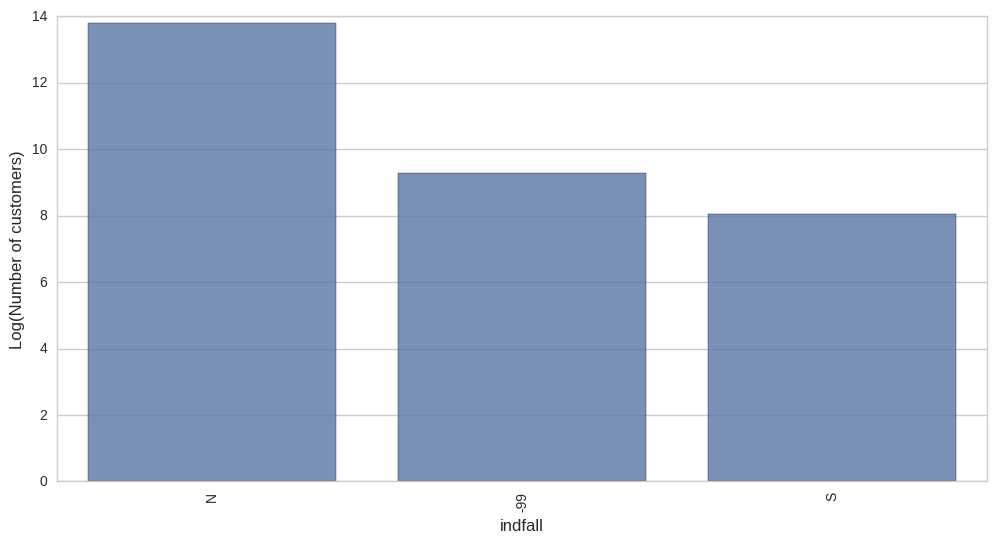


Number of unique values in  tipodom  :  2


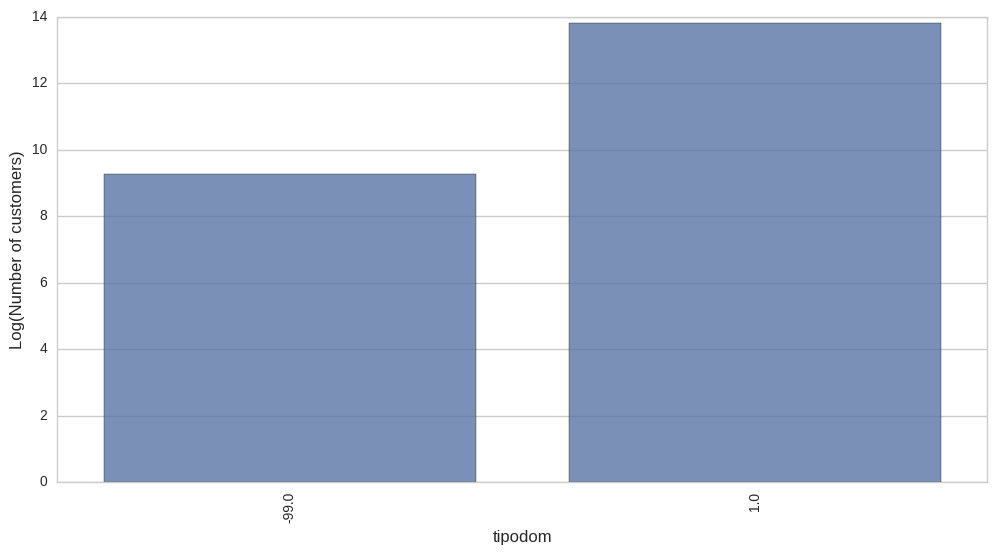


Number of unique values in  cod_prov  :  53


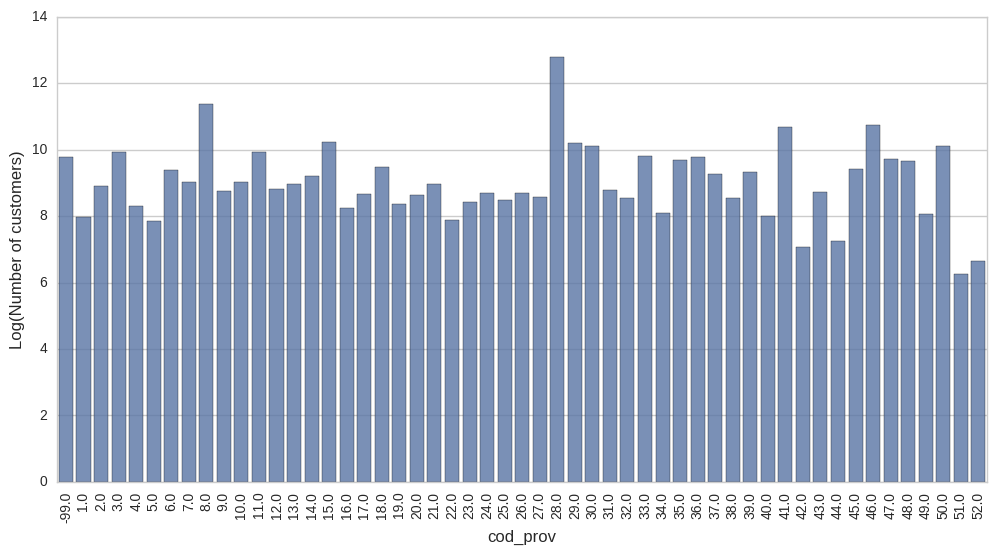


Number of unique values in  ind_actividad_cliente  :  3


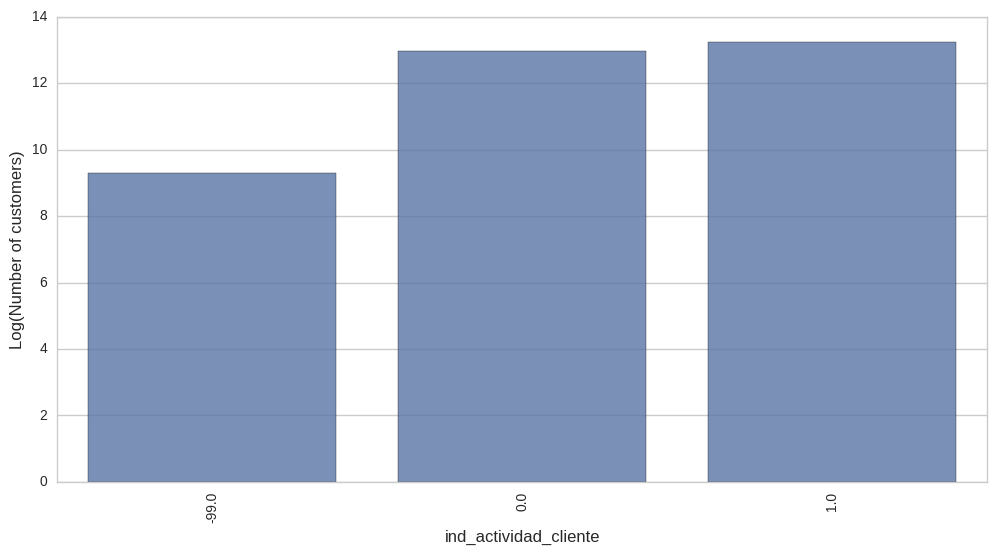


Number of unique values in  segmento  :  4


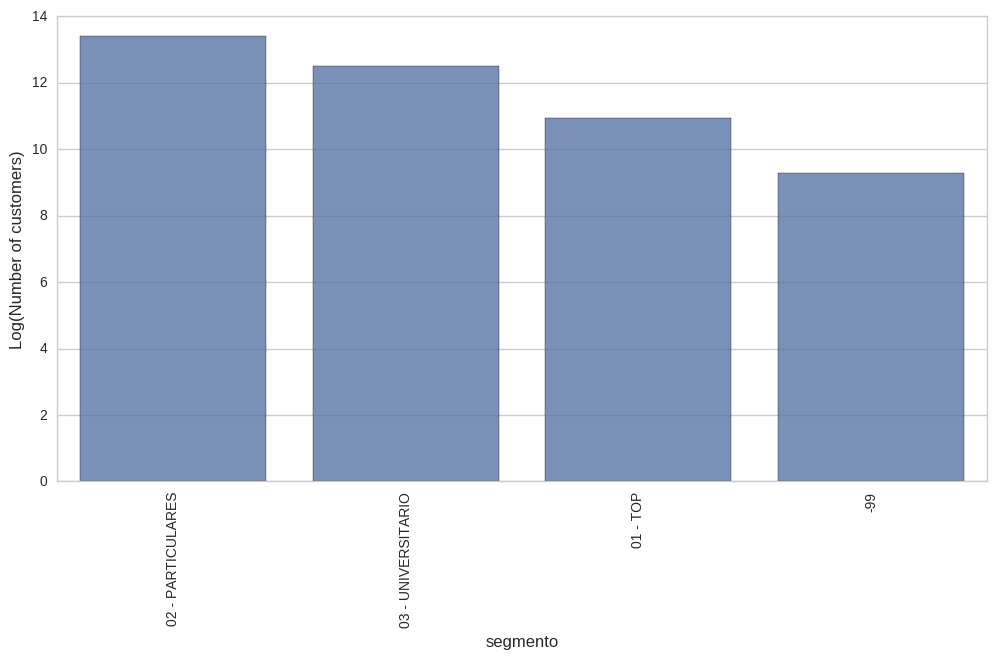

In [20]:
cols = ["ind_empleado","pais_residencia","sexo","ind_nuevo","indrel","ult_fec_cli_1t","indrel_1mes",
        "tiprel_1mes","indresi","indext","conyuemp","canal_entrada","indfall","tipodom","cod_prov",
        "ind_actividad_cliente","segmento"]
for col in cols:
    train = pd.read_csv("train_ver2.csv", usecols = ["ncodpers", col], nrows=1000000)
    train = train.fillna(-99)
    len_unique = len(train[col].unique())
    print "Number of unique values in ",col," : ",len_unique 
    if len_unique < 200:
        agg_df = train[col].value_counts()
        plt.figure(figsize=(12,6))
        sns.barplot(agg_df.index, np.log1p(agg_df.values), alpha=0.8, color=color[0])
        plt.xlabel(col, fontsize=12)
        plt.ylabel('Log(Number of customers)', fontsize=12)
        plt.xticks(rotation='vertical')
        plt.show()
    print

## 2. Data Preprocessing

Mapping dictionary for categorical features..

In [5]:
mapping_dict = {
'ind_empleado'  : {-99:0, 'N':1, 'B':2, 'F':3, 'A':4, 'S':5},
'sexo'          : {'V':0, 'H':1, -99:2},
'ind_nuevo'     : {'0':0, '1':1, -99:2},
'indrel'        : {'1':0, '99':1, -99:2},
'indrel_1mes'   : {-99:0, '1.0':1, '1':1, '2.0':2, '2':2, '3.0':3, '3':3, '4.0':4, '4':4, 'P':5},
'tiprel_1mes'   : {-99:0, 'I':1, 'A':2, 'P':3, 'R':4, 'N':5},
'indresi'       : {-99:0, 'S':1, 'N':2},
'indext'        : {-99:0, 'S':1, 'N':2},
'conyuemp'      : {-99:0, 'S':1, 'N':2},
'indfall'       : {-99:0, 'S':1, 'N':2},
'tipodom'       : {-99:0, '1':1},
'ind_actividad_cliente' : {'0':0, '1':1, -99:2},
'segmento'      : {'02 - PARTICULARES':0, '03 - UNIVERSITARIO':1, '01 - TOP':2, -99:3},
'pais_residencia' : {'LV': 102, 'BE': 12, 'BG': 50, 'BA': 61, 'BM': 117, 'BO': 62, 'JP': 82, 'JM': 116,
                     'BR': 17, 'BY': 64, 'BZ': 113, 'RU': 43, 'RS': 89, 'RO': 41, 'GW': 99, 'GT': 44, 'GR': 39,
                     'GQ': 73, 'GE': 78, 'GB': 9, 'GA': 45, 'GN': 98, 'GM': 110, 'GI': 96, 'GH': 88, 'OM': 100,
                     'HR': 67, 'HU': 106, 'HK': 34, 'HN': 22, 'AD': 35, 'PR': 40, 'PT': 26, 'PY': 51, 'PA': 60,
                     'PE': 20, 'PK': 84, 'PH': 91, 'PL': 30, 'EE': 52, 'EG': 74, 'ZA': 75, 'EC': 19, 'AL': 25,
                     'VN': 90, 'ET': 54, 'ZW': 114, 'ES': 0, 'MD': 68, 'UY': 77, 'MM': 94, 'ML': 104, 'US': 15,
                     'MT': 118, 'MR': 48, 'UA': 49, 'MX': 16, 'IL': 42, 'FR': 8, 'MA': 38, 'FI': 23, 'NI': 33,
                     'NL': 7, 'NO': 46, 'NG': 83, 'NZ': 93, 'CI': 57, 'CH': 3, 'CO': 21, 'CN': 28, 'CM': 55,
                     'CL': 4, 'CA': 2, 'CG': 101, 'CF': 109, 'CD': 112, 'CZ': 36, 'CR': 32, 'CU': 72, 'KE': 65,
                     'KH': 95, 'SV': 53, 'SK': 69, 'KR': 87, 'KW': 92, 'SN': 47, 'SL': 97, 'KZ': 111, 'SA': 56,
                     'SG': 66, 'SE': 24, 'DO': 11, 'DJ': 115, 'DK': 76, 'DE': 10, 'DZ': 80, 'MK': 105, -99: 1, 
                     'LB': 81, 'TW': 29, 'TR': 70, 'TN': 85, 'LT': 103, 'LU': 59, 'TH': 79, 'TG': 86, 'LY': 108, 
                     'AE': 37, 'VE': 14, 'IS': 107, 'IT': 18, 'AO': 71, 'AR': 13, 'AU': 63, 'AT': 6, 'IN': 31,
                     'IE': 5, 'QA': 58, 'MZ': 27},
'canal_entrada' : {'013': 49, 'KHP': 160, 'KHQ': 157, 'KHR': 161, 'KHS': 162, 'KHK': 10, 'KHL': 0, 'KHM': 12, 
                   'KHN': 21, 'KHO': 13, 'KHA': 22, 'KHC': 9, 'KHD': 2, 'KHE': 1, 'KHF': 19, '025': 159, 'KAC': 57,
                   'KAB': 28, 'KAA': 39, 'KAG': 26, 'KAF': 23, 'KAE': 30, 'KAD': 16, 'KAK': 51, 'KAJ': 41, 'KAI': 35, 
                   'KAH': 31, 'KAO': 94, 'KAN': 110, 'KAM': 107, 'KAL': 74, 'KAS': 70, 'KAR': 32, 'KAQ': 37, 'KAP': 46,
                   'KAW': 76, 'KAV': 139, 'KAU': 142, 'KAT': 5, 'KAZ': 7, 'KAY': 54, 'KBJ': 133, 'KBH': 90, 'KBN': 122,
                   'KBO': 64, 'KBL': 88, 'KBM': 135, 'KBB': 131, 'KBF': 102, 'KBG': 17, 'KBD': 109, 'KBE': 119, 
                   'KBZ': 67, 'KBX': 116, 'KBY': 111, 'KBR': 101, 'KBS': 118, 'KBP': 121, 'KBQ': 62, 'KBV': 100, 
                   'KBW': 114, 'KBU': 55, 'KCE': 86, 'KCD': 85, 'KCG': 59, 'KCF': 105, 'KCA': 73, 'KCC': 29, 'KCB': 78,
                   'KCM': 82, 'KCL': 53, 'KCO': 104, 'KCN': 81, 'KCI': 65, 'KCH': 84, 'KCK': 52, 'KCJ': 156, 
                   'KCU': 115, 'KCT': 112, 'KCV': 106, 'KCQ': 154, 'KCP': 129, 'KCS': 77, 'KCR': 153, 'KCX': 120,
                   'RED': 8, 'KDL': 158, 'KDM': 130, 'KDN': 151, 'KDO': 60, 'KDH': 14, 'KDI': 150, 'KDD': 113, 
                   'KDE': 47, 'KDF': 127, 'KDG': 126, 'KDA': 63, 'KDB': 117, 'KDC': 75, 'KDX': 69, 'KDY': 61, 
                   'KDZ': 99, 'KDT': 58, 'KDU': 79, 'KDV': 91, 'KDW': 132, 'KDP': 103, 'KDQ': 80, 'KDR': 56, 
                   'KDS': 124, 'K00': 50, 'KEO': 96, 'KEN': 137, 'KEM': 155, 'KEL': 125, 'KEK': 145, 'KEJ': 95, 
                   'KEI': 97, 'KEH': 15, 'KEG': 136, 'KEF': 128, 'KEE': 152, 'KED': 143, 'KEC': 66, 'KEB': 123, 
                   'KEA': 89, 'KEZ': 108, 'KEY': 93, 'KEW': 98, 'KEV': 87, 'KEU': 72, 'KES': 68, 'KEQ': 138, -99: 6,
                   'KFV': 48, 'KFT': 92, 'KFU': 36, 'KFR': 144, 'KFS': 38, 'KFP': 40, 'KFF': 45, 'KFG': 27, 'KFD': 25,
                   'KFE': 148, 'KFB': 146, 'KFC': 4, 'KFA': 3, 'KFN': 42, 'KFL': 34, 'KFM': 141, 'KFJ': 33, 'KFK': 20, 
                   'KFH': 140, 'KFI': 134, '007': 71, '004': 83, 'KGU': 149, 'KGW': 147, 'KGV': 43, 'KGY': 44, 'KGX': 24,
                   'KGC': 18, 'KGN': 11}
}

In [6]:
cat_cols = list(mapping_dict.keys())

I don't use the first two products for predicting because they have very small number of buys.

In [7]:
target_cols = ['ind_ahor_fin_ult1','ind_aval_fin_ult1','ind_cco_fin_ult1','ind_cder_fin_ult1','ind_cno_fin_ult1',
               'ind_ctju_fin_ult1','ind_ctma_fin_ult1','ind_ctop_fin_ult1','ind_ctpp_fin_ult1','ind_deco_fin_ult1',
               'ind_deme_fin_ult1','ind_dela_fin_ult1','ind_ecue_fin_ult1','ind_fond_fin_ult1','ind_hip_fin_ult1',
               'ind_plan_fin_ult1','ind_pres_fin_ult1','ind_reca_fin_ult1','ind_tjcr_fin_ult1','ind_valo_fin_ult1',
               'ind_viv_fin_ult1','ind_nomina_ult1','ind_nom_pens_ult1','ind_recibo_ult1']
target_cols = target_cols[2:]

Getting the target features is easy..

In [8]:
def getTarget(row):
    tlist = []
    for col in target_cols:
        if row[col].strip() in ['', 'NA']:
            target = 0
        else:
            target = int(float(row[col]))
        tlist.append(target)
    return tlist

Getting categorical features via mapping dictionary..

In [9]:
def getIndex(row, col):
    val = row[col].strip()
    if val not in ['','NA']:
        ind = mapping_dict[col][val]
    else:
        ind = mapping_dict[col][-99]
    return ind

The next three functions are for three numerical features. Replace missing values with the mean and cut the boundaries.

In [10]:
def getAge(row):
    mean_age = 40.
    min_age = 20.
    max_age = 90.
    range_age = max_age - min_age
    age = row['age'].strip()
    if age == 'NA' or age == '':
        age = mean_age
    else:
        age = float(age)
        if age < min_age:
            age = min_age
        elif age > max_age:
            age = max_age
    return round( (age - min_age) / range_age, 4)

In [11]:
def getCustSeniority(row):
    min_value = 0.
    max_value = 256.
    range_value = max_value - min_value
    missing_value = 0.
    cust_seniority = row['antiguedad'].strip()
    if cust_seniority == 'NA' or cust_seniority == '':
        cust_seniority = missing_value
    else:
        cust_seniority = float(cust_seniority)
        if cust_seniority < min_value:
            cust_seniority = min_value
        elif cust_seniority > max_value:
            cust_seniority = max_value
    return round((cust_seniority-min_value) / range_value, 4)

In [12]:
def getRent(row):
    min_value = 0.
    max_value = 1500000.
    range_value = max_value - min_value
    missing_value = 101850.
    rent = row['renta'].strip()
    if rent == 'NA' or rent == '':
        rent = missing_value
    else:
        rent = float(rent)
        if rent < min_value:
            rent = min_value
        elif rent > max_value:
            rent = max_value
    return round((rent-min_value) / range_value, 6)

And the last feature that I think will be usefull is the time from the moment when the customer began to be the bank contract holder to the moment of the purchase.

In [13]:
def getTime(row):
    min_value = 0
    max_value = 100.0*365
    range_value = max_value - min_value
    start_time = row['fecha_alta'].strip()
    stop_time = row['fecha_dato'].strip()
    try:
        if start_time[0] == '':
            start_time = start_time[1:]
        if stop_time[0] == '':
            stop_time = stop_time[1:]
        temp = (int(stop_time[:stop_time.find('-')])-int(start_time[:start_time.find('-')]))*365
        temp += (int(stop_time[stop_time.find('-'):stop_time.find('-',stop_time.find('-'))]) - 
                 int(start_time[start_time.find('-'):start_time.find('-',start_time.find('-'))])) * 30
        if temp <min_value :
            temp = min_value
        if temp > max_value:
            temp = max_value
        return round((temp-min_value) / range_value, 6)
    except:
        return 0.1

Now, all together in one function. Important that I will consider only June 2015 for training. It is reasonable for reducing the size of the data significantly because I have the limited memory resourses. Also, it was shown that June is a special month and maybe it is good to consider it apart of the others. Besides, we are trying to predict new products for June 2016.

Important! I will consider only those logs of June 2015 that have new products comparing to the previous month of May 2015. Also, I extend the input space by the list of the products from the previous months May 2015 and May 2016 for the train and test datasets respectively.

In [14]:
def processData(in_file_name, cust_dict):
    x_vars_list = []
    y_vars_list = []
    for row in csv.DictReader(in_file_name):
        if row['fecha_dato'] not in ['2015-05-28', '2015-06-28', '2016-05-28', '2016-06-28']:
            continue
        cust_id = int(row['ncodpers'])
        if row['fecha_dato'] in ['2015-05-28', '2016-05-28']:
            target_list = getTarget(row)
            cust_dict[cust_id] =  target_list[:]
            continue
        x_vars = []
        for col in cat_cols:
            x_vars.append(getIndex(row, col))
        x_vars.append(getAge(row))
        x_vars.append(getCustSeniority(row))
        x_vars.append(getRent(row))
        x_vars.append(getTime(row))
        if row['fecha_dato'] == '2016-06-28':
            prev_target_list = cust_dict.get(cust_id, [0]*22)
            x_vars_list.append(x_vars + prev_target_list)
        elif row['fecha_dato'] == '2015-06-28':
            prev_target_list = cust_dict.get(cust_id, [0]*22)
            target_list = getTarget(row)
            new_products = [max(x1 - x2,0) for (x1, x2) in zip(target_list, prev_target_list)]
            if sum(new_products) > 0:
                for ind, prod in enumerate(new_products):
                    if prod>0:
                        assert len(prev_target_list) == 22
                        x_vars_list.append(x_vars+prev_target_list)
                        y_vars_list.append(ind)
    return x_vars_list, y_vars_list, cust_dict

In [15]:
train_file = open("train_ver2.csv")
x_vars_list, y_vars_list, cust_dict = processData(train_file, {})
train_X = np.array(x_vars_list)
train_y = np.array(y_vars_list)
del x_vars_list, y_vars_list
train_file.close()
test_file = open("test_ver2.csv")
x_vars_list, y_vars_list, cust_dict = processData(test_file, cust_dict)
test_X = np.array(x_vars_list)
del x_vars_list
test_file.close()

## 3. Training and Predicting

### XGBoost

In [148]:
def runXGB(train_X, train_y, seed_val=123):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.06
    param['max_depth'] = 6
    param['silent'] = 1
    param['num_class'] = 22
    param['eval_metric'] = "map@7"
    param['min_child_weight'] = 1
    param['subsample'] = 0.8
    param['colsample_bytree'] = 0.8
    param['seed'] = seed_val
    num_rounds = 60
    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)
    model = xgb.train(plst, xgtrain, num_rounds)
    return model

In [ ]:
print("Building model..")
model = runXGB(train_X, train_y, seed_val=0)
print("Predicting..")
xgtest = xgb.DMatrix(test_X)
preds = model.predict(xgtest)
print("Getting the top products..")
target_cols = np.array(target_cols)
preds = np.argsort(preds, axis=1)
preds = np.fliplr(preds)[:,:7]
test_id = np.array(pd.read_csv("test_ver2.csv", usecols=['ncodpers'])['ncodpers'])
final_preds = [" ".join(list(target_cols[pred])) for pred in preds]
out_df = pd.DataFrame.from_items([('ncodpers', test_id), ('added_products', final_preds)])
out_df.to_csv('xgb.csv', index=False)

### K-Nearest Neighbors

In [49]:
print("Building model..")
clf = KNeighborsClassifier()
clf = clf.fit(train_X, train_y)
print("Predicting..")
preds = clf.predict_proba(test_X)

In [57]:
print("Getting the top products..")
target_cols = np.array(target_cols)
preds = np.argsort(preds, axis=1)
preds = np.fliplr(preds)[:,:7]
test_id = np.array(pd.read_csv("test_ver2.csv", usecols=['ncodpers'])['ncodpers'])
final_preds = [" ".join(list(target_cols[pred])) for pred in preds]
out_df = pd.DataFrame.from_items([('ncodpers', test_id), ('added_products', final_preds)])
out_df.to_csv('knn.csv', index=False)

### Neural Networks

In [16]:
import time
import lasagne
import theano
import theano.tensor as T

#### Model 1

In [593]:
input_X = T.imatrix()
target_y = T.ivector()

In [594]:
input_layer = lasagne.layers.InputLayer(shape=(None, 41), input_var=input_X)
nn = lasagne.layers.DenseLayer(input_layer, num_units=38, nonlinearity=lasagne.nonlinearities.rectify)
nn = lasagne.layers.DenseLayer(nn, num_units=28, nonlinearity = lasagne.nonlinearities.rectify)
nn_output = lasagne.layers.DenseLayer(nn, num_units = 22, nonlinearity = lasagne.nonlinearities.softmax)

In [595]:
y_predicted = lasagne.layers.get_output(nn_output)
all_weights = lasagne.layers.get_all_params(nn_output, trainable=True)

In [596]:
loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()
updates_sgd = lasagne.updates.adam(loss, all_weights, learning_rate=0.01)

In [597]:
train_fun = theano.function([input_X,target_y],[loss,accuracy], allow_input_downcast=True, updates=updates_sgd)

In [598]:
y_predicted_det = lasagne.layers.get_output(nn_output, deterministic=True)
accuracy_det = lasagne.objectives.categorical_accuracy(y_predicted_det, target_y).mean()
accuracy_fun = theano.function([input_X,target_y], accuracy_det)

In [599]:
def iterate_minibatches(X, y, batchsize):
    assert len(X) == len(y)
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    for start_idx in range(0, len(X) - batchsize + 1, batchsize):
        excerpt = indices[start_idx:start_idx + batchsize]
        yield X[excerpt], y[excerpt]

In [600]:
num_epochs = 5         
batch_size = 1000

for epoch in range(num_epochs):
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time() 
    for batch in iterate_minibatches(train_X, train_y, batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch = train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))

Epoch 1 of 5 took 0.956s
  training loss (in-iteration):		2.104844
  train accuracy:		33.27 %
Epoch 2 of 5 took 0.749s
  training loss (in-iteration):		1.593866
  train accuracy:		49.17 %
Epoch 3 of 5 took 0.652s
  training loss (in-iteration):		1.486923
  train accuracy:		51.92 %
Epoch 4 of 5 took 0.794s
  training loss (in-iteration):		1.431879
  train accuracy:		52.73 %
Epoch 5 of 5 took 0.984s
  training loss (in-iteration):		1.403931
  train accuracy:		52.88 %


In [80]:
pred_fun = theano.function([input_X], [y_predicted_det], allow_input_downcast=True)

In [ ]:
y_pred = pred_fun(test_X)

In [82]:
preds = y_pred[0]

In [83]:
print("Getting the top products..")
target_cols = np.array(target_cols)
preds = np.argsort(preds, axis=1)
preds = np.fliplr(preds)[:,:7]
test_id = np.array(pd.read_csv("test_ver2.csv", usecols=['ncodpers'])['ncodpers'])
final_preds = [" ".join(list(target_cols[pred])) for pred in preds]
out_df = pd.DataFrame.from_items([('ncodpers', test_id), ('added_products', final_preds)])
out_df.to_csv('nn.csv', index=False)

Getting the top products..


#### Model 2

In [601]:
inputs = []
for col in cat_cols:
    inputs.append(T.ivector())
for col in target_cols:
    inputs.append(T.ivector())
inputs.append(T.imatrix())
inputs.append(T.ivector())

In [602]:
inputs_layers = []
i = 0
for col in cat_cols:
    inputs_layers.append(lasagne.layers.InputLayer((None, ), input_var=inputs[i]))
    i = i + 1
for col in target_cols:
    inputs_layers.append(lasagne.layers.InputLayer((None, ), input_var=inputs[i]))
    i = i + 1
inputs_layers.append(lasagne.layers.InputLayer((None, 4), input_var=inputs[i]))
concat_layers = []
i = 0
for col in cat_cols:
    concat_layers.append(lasagne.layers.EmbeddingLayer(inputs_layers[i], input_size=max(train_X[:,i])+1, 
                                                          output_size=32))
    i = i + 1
for col in target_cols:
    concat_layers.append(lasagne.layers.EmbeddingLayer(inputs_layers[i], input_size=max(train_X[:,4+i])+1, 
                                                          output_size=32))
    i = i + 1
concat_layers.append(lasagne.layers.DenseLayer(inputs_layers[i], 
                                               num_units=16, nonlinearity=lasagne.nonlinearities.rectify))
nn1 = lasagne.layers.concat(concat_layers)
nn2 = lasagne.layers.DenseLayer(nn1, 1024, nonlinearity=lasagne.nonlinearities.rectify)
nn3 = lasagne.layers.DenseLayer(nn2, 512, nonlinearity=lasagne.nonlinearities.rectify)
nn3 = lasagne.layers.DenseLayer(nn3, 256, nonlinearity=lasagne.nonlinearities.rectify)
nn3 = lasagne.layers.DenseLayer(nn3, 128, nonlinearity=lasagne.nonlinearities.rectify)
nn3 = lasagne.layers.DenseLayer(nn3, 64, nonlinearity=lasagne.nonlinearities.rectify)
n_output = lasagne.layers.DenseLayer(nn3, 22, nonlinearity=lasagne.nonlinearities.softmax)

In [603]:
y_predicted = lasagne.layers.get_output(n_output)
all_weights = lasagne.layers.get_all_params(n_output, trainable=True)

In [604]:
loss = lasagne.objectives.categorical_crossentropy(y_predicted,inputs[-1]).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted,inputs[-1]).mean()
updates_sgd = lasagne.updates.adam(loss, all_weights, learning_rate=0.01)

In [605]:
train_fun = theano.function(inputs, [loss,accuracy], allow_input_downcast=True, updates=updates_sgd)

In [606]:
y_predicted_det = lasagne.layers.get_output(n_output,deterministic=True)
accuracy_det = lasagne.objectives.categorical_accuracy(y_predicted_det,inputs[-1]).mean()
accuracy_fun = theano.function(inputs, accuracy_det)

In [607]:
def iterate_minibatches(*arrays,**kwargs):
    batchsize=kwargs.get("batchsize",100)
    shuffle = kwargs.get("shuffle",True)
    if shuffle:
        indices = np.arange(len(arrays[0]))
        np.random.shuffle(indices)
    for start_idx in range(0, len(arrays[0]) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield [arr[excerpt] for arr in arrays]

In [608]:
num_epochs = 3      
batch_size = 1000

for epoch in range(num_epochs):
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(train_X[:,0], train_X[:,1], train_X[:,2], train_X[:,3],
                                     train_X[:,4], train_X[:,5], train_X[:,6], train_X[:,7], train_X[:,8], 
                                     train_X[:,9], train_X[:,10], train_X[:,11], train_X[:,12], train_X[:,13], 
                                     train_X[:,14], train_X[:,19], train_X[:,20],
                                     train_X[:,21], train_X[:,22], train_X[:,23], train_X[:,24], train_X[:,25],
                                     train_X[:,26], train_X[:,27], train_X[:,28], train_X[:,29], train_X[:,30],
                                     train_X[:,31], train_X[:,32], train_X[:,33], train_X[:,34], train_X[:,35], 
                                     train_X[:,36], train_X[:,37], train_X[:,38], train_X[:,39], train_X[:,40], 
                                     train_X[:,15:19], train_y, batchsize=batch_size,shuffle=True):
        inp0, inp1, inp2, inp3, inp4, inp5, inp6, inp7, inp8, inp9,\
        inp10, inp11, inp12, inp13, inp14, inp15, inp16, inp17, inp18,\
        inp19, inp20, inp21, inp22, inp23, inp24, inp25, inp26, inp27,\
        inp28, inp29, inp30, inp31, inp32, inp33, inp34, inp35, inp36, inp37, inp38 = batch
        train_err_batch, train_acc_batch = train_fun(inp0, inp1, inp2, inp3, inp4, inp5, inp6, inp7, inp8, inp9,
                                                     inp10, inp11, inp12, inp13, inp14, inp15, inp16, inp17, inp18,
                                                     inp19, inp20, inp21, inp22, inp23, inp24, inp25, inp26, inp27,
                                                     inp28, inp29, inp30, inp31, inp32, inp33, inp34, inp35, inp36, 
                                                     inp37, inp38)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1      
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))

Epoch 1 of 3 took 95.933s
  training loss (in-iteration):		2.151759
  train accuracy:		25.24 %
Epoch 2 of 3 took 85.639s
  training loss (in-iteration):		1.718219
  train accuracy:		44.14 %
Epoch 3 of 3 took 72.985s
  training loss (in-iteration):		1.505940
  train accuracy:		51.39 %


## 4. Comparing and Analysis of the Results

In [576]:
results = [0.0288482, 0.022102, 0.0259509]
pd.DataFrame(results, index = ['xgb', 'knn', 'nn'], columns=['Public Score MAP@7'])

,Public Score MAP@7
xgb,0.028848
knn,0.022102
nn,0.025951


As expected, knn is the worst here, because it is very simple model for this task. Unfortunately, xgb score was not improved by neural networks. Even the model with embedding for categorical features was not able to reach something higher than around 55% accuracy on train.

Of course, the better results can be achieved by using more training data.